# Train A Shape Classifier Model



In [1]:
import json
import os

train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (including resizing and normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (black and white images)
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_data_root, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names (optional)
print(f'Classes: {train_dataset.classes}')

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: circle, triangle, rectangle
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # First Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = F.relu(self.conv2(x))   # Second Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))     # Fully Connected Layer 1
        x = self.fc2(x)             # Fully Connected Layer 2 (output)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


Classes: ['circle', 'diamond', 'triangle']


# Train

In [8]:
train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Loss: 1.1167, Accuracy: 35.00%
Epoch [2/15], Loss: 1.0439, Accuracy: 46.57%
Epoch [3/15], Loss: 0.9792, Accuracy: 49.86%
Epoch [4/15], Loss: 0.8726, Accuracy: 58.00%
Epoch [5/15], Loss: 0.7343, Accuracy: 68.43%
Epoch [6/15], Loss: 0.5314, Accuracy: 82.86%
Epoch [7/15], Loss: 0.3591, Accuracy: 89.14%
Epoch [8/15], Loss: 0.2352, Accuracy: 92.71%
Epoch [9/15], Loss: 0.1544, Accuracy: 95.29%
Epoch [10/15], Loss: 0.0977, Accuracy: 98.29%
Epoch [11/15], Loss: 0.0705, Accuracy: 98.43%
Epoch [12/15], Loss: 0.0451, Accuracy: 99.43%
Epoch [13/15], Loss: 0.0235, Accuracy: 100.00%
Epoch [14/15], Loss: 0.0162, Accuracy: 100.00%
Epoch [15/15], Loss: 0.0096, Accuracy: 100.00%


# Test 

In [10]:
from sklearn.metrics import classification_report
def test(model, test_loader):
    """Print the Precision, Recall and F1-score for the trained model
    """
    model.eval()
    y_true, y_pred = [],[]
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    target_names = test_dataset.classes
    print(classification_report(y_true, y_pred, target_names=target_names))
test(model, test_loader)

              precision    recall  f1-score   support

      circle       0.69      0.62      0.65       105
     diamond       0.65      0.70      0.67       103
    triangle       0.91      0.93      0.92        92

    accuracy                           0.74       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.74      0.74      0.74       300



Training Data Distribution: Counter({'diamond': 251, 'triangle': 227, 'circle': 222})


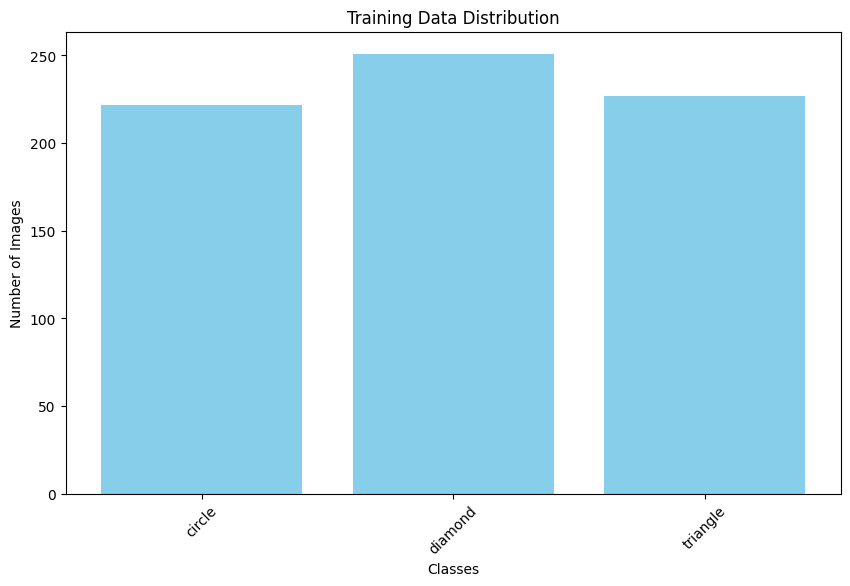

Testing Data Distribution: Counter({'circle': 105, 'diamond': 103, 'triangle': 92})


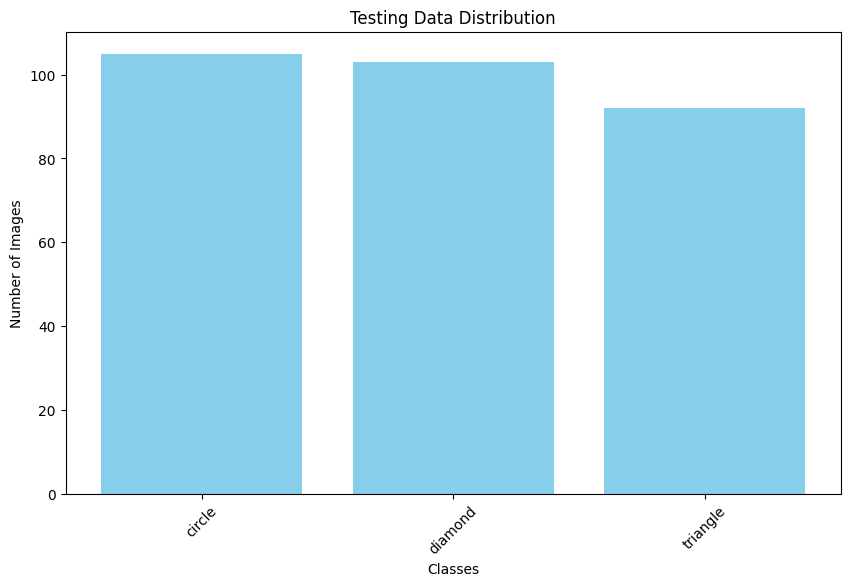

In [17]:
import os
from collections import Counter
import matplotlib.pyplot as plt

def get_data_distribution(data_root):
    """Get the distribution of images in each class."""
    class_counts = Counter()
    for class_name in os.listdir(data_root):
        class_path = os.path.join(data_root, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

def plot_data_distribution(distribution, title):
    """Plot the data distribution as a bar chart."""
    classes = list(distribution.keys())
    counts = list(distribution.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Paths to the train and test datasets
train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

# Get data distributions
train_distribution = get_data_distribution(train_data_root)
test_distribution = get_data_distribution(test_data_root)

# Plot data distributions
print("Training Data Distribution:", train_distribution)
plot_data_distribution(train_distribution, "Training Data Distribution")

print("Testing Data Distribution:", test_distribution)
plot_data_distribution(test_distribution, "Testing Data Distribution")

# Show Predictions


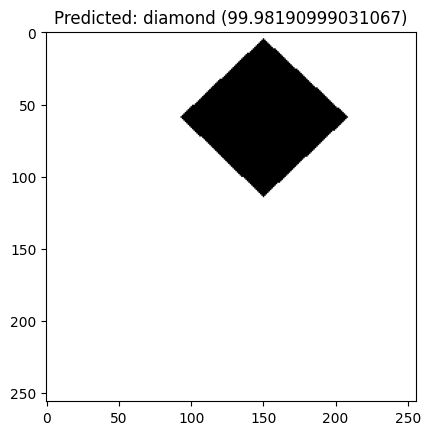

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
def show_prediction(model, image):
    """Pass the image to the model and overlay the predicted shape and confidence on the input
    image and display it
    """
    model.eval()
    img = Image.open(image).convert("L")
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
    ])
    img_tensor = transform(img).unsqueeze(0).to(device) # add a batch dimension (1, 1, 64, 64)

    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)
    label = test_dataset.classes[predicted.item()]
    plt.imshow(img, cmap="gray")
    plt.title(f"Predicted: {label} ({confidence.item() * 100})")
    plt.show()
show_prediction(model, r"C:\Users\Admin\Downloads\Nathan-ML-intern-skills-test\datasets\train\diamond\diamond_12.png")
